# Desafio Data Science Semantix

## Análise de Campanha de Marketing Bancária

Um banco de Portugal realizou uma campanha de Marketing para adesão de seus clientes a um plano de investimentos.
Dados sobre tal campanha estão disponíveis.
Nosso intuito é promover alguns *insights* sobre tais dados, para entender um pouco melhor o perfil dos investidores.

#### *Imports* necessários

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

#### Carregamento dos dados
Previamente, os dados brutos, em formato CSV (*Comma-spaced values*), foram carregados e, a cada coluna, atribuídos os tipos corretos, pensando em eficiência computacional e categorização de dados.
O resultado foi salvo em um arquivo binário, menor que o compactado original.

In [2]:
bank = pd.read_pickle('../data/clean.pkl.gz')

Foram propostos alguns questionamentos sobre esse conjunto de dados, que espero conseguir responder de forma simples e didática.
A cada questionamento, uma série de tabelas e gráficos nos ajudarão pelo caminho.

### Qual profissão tem mais tendência a fazer um empréstimo? De qual tipo?

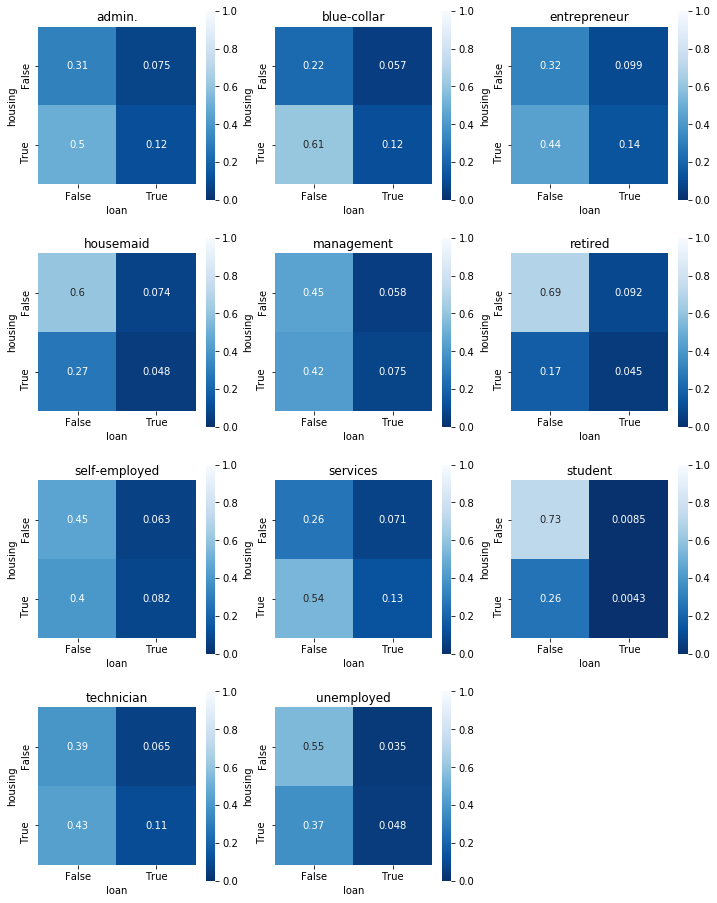

In [3]:
data = (bank.groupby(['job', 'housing', 'loan']).size()/bank.groupby('job').size())
fig, axes = plt.subplots(4,3, figsize=(12, 16))
axes = np.array(axes).ravel()
fig.delaxes(axes[-1])

for ax, (job, job_data) in zip(axes, data.groupby('job')):
    sns.heatmap(
        job_data.reset_index(level=0, drop=True).unstack(),
        ax=ax,
        cmap='Blues_r',
        vmin=0, vmax=1,
        annot=True,
        square=True
    )
    ax.set_title(job)

Podemos ver, por inspeção, que as profissões que mais possuem tendência a ter empréstimos são os *blue-collar* e os que trabalham no setor de serviços, com 88% e 84% dos clientes tendo algum tipo de empréstimo.
Também podemos ver que financiamento imobiliário é o mais comum, e não apenas entre esses clientes:

In [4]:
pd.concat((
    data.groupby(['job', 'housing']).sum()[:, True].rename('housing'),
    data.groupby(['job', 'loan']).sum()[:, True].rename('loan')
), axis=1)

,housing,loan
job,,
admin.,0.615355,0.191646
blue-collar,0.724209,0.173037
entrepreneur,0.584398,0.239408
housemaid,0.320968,0.122581
management,0.494608,0.132480
retired,0.216873,0.136484
self-employed,0.484484,0.145028
services,0.665864,0.201252
student,0.265458,0.012793


O financiamento imobiliário é, de fato, mais comum entre todas as categorias trabalhistas analisadas.

### Relação número de contatos e resultado da campanha

Existem dois questionamentos sobre isso:

####  Fazendo uma relação entre número de contatos e sucesso da campanha quais são os pontos relevantes a serem observados?
#### Baseando-se nos resultados de adesão desta campanha qual o número médio e o máximo de ligações que você indica para otimizar a adesão?

Para tanto, precisamos observar quantos contatos foram feitos para cada cliente, e comparar com o resultado da campanha.

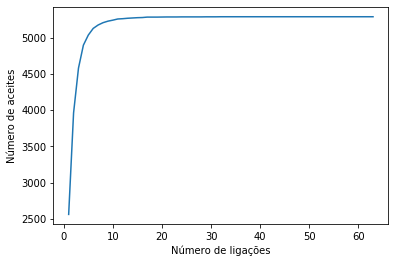

In [5]:
data = bank[['campaign', 'y']]\
    .groupby('campaign')\
    .sum().cumsum()
ax = data.plot(legend=False)
ax.set_xlabel('Número de ligações');
ax.set_ylabel('Número de aceites');

Podemos ver que a maior parte dos clientes que aceitaram, o fizeram nas primeiras ligações.
Após algo próximo de 8 ligações, a efetividade de uma nova ligação é praticamente nula, talvez pela importunação.
Precisaríamos saber mais a fundo qual a periodicidade de cada contato (já que temos o intervalo desde o último, e não de cada um) para avaliar melhor essa hipótese.
O fato é que uma campanha com um máximo manejável de contatos (e não 63 como houve um cliente) se torna mais eficiente, por não despender recursos em colaboradores com clientes que não tem interesse.

Um bom máximo de ligações é o número correspondente ao cotovelo do gráfico acima, pois a partir dele, se torna inefetivo novos contatos.
Uma boa média é a metade desse máximo.
Fazendo uma ampliação no trecho 0-10, podemos concluir que um bom máximo e uma boa média de contatos com o cliente em uma campanha são, respectivamente, 6 e 3.

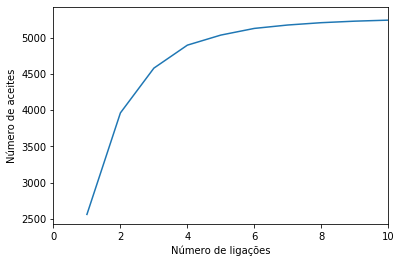

In [6]:
ax = data.plot(xlim=(0,10), legend=False)
ax.set_xlabel('Número de ligações');
ax.set_ylabel('Número de aceites');

### O resultado da campanha anterior tem relevância na campanha atual?

Temos alguns dados sobre uma campanha anterior feita pelo mesmo banco, aos mesmos clientes.
Precisamos analisar se o sucesso ou fracasso da campanha atual tem relação com sucesso e fracasso anterior.

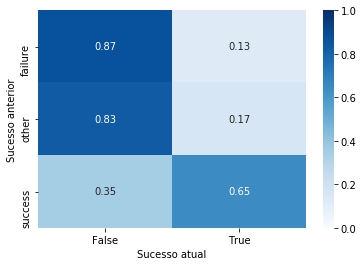

In [7]:
data = (bank.groupby(['poutcome', 'y']).size()/bank.groupby('poutcome').size()).unstack()

ax = sns.heatmap(
    data,
    cmap='Blues',
    annot=True,
    vmin=0, vmax=1
)

ax.set_xlabel('Sucesso atual')
ax.set_ylabel('Sucesso anterior');

Ou seja, um cliente que aceitou uma proposta em campanha anterior tem uma boa chance de aceitar uma nova proposta.
Mas o mais interessante é a rejeição de ofertas agora, para os que rejeitaram a anterior.

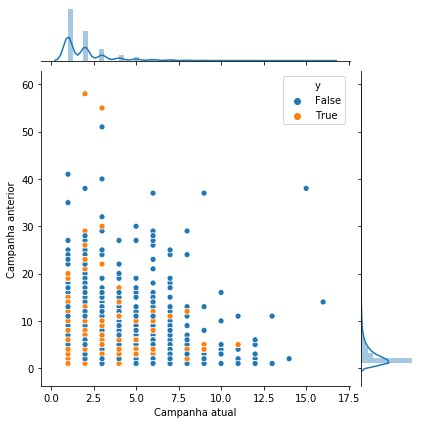

In [8]:
data = bank.query('previous > 0 and previous < 250')
g = sns.JointGrid(x='campaign', y='previous', data=data)
g = g.plot_joint(sns.scatterplot, hue=data['y'])
g = g.plot_marginals(sns.distplot)
g = g.set_axis_labels('Campanha atual', 'Campanha anterior')

No entanto, não podemos dizer que um número maior de contatos em campanha anterior tenha levado à aceitação ou à rejeição na campanha atual.

#### Quais são as características mais proeminentes de um cliente que possua empréstimo imobiliário?

Vimos anteriormente que muitos clientes possuem empréstimos imobiliários.
Dessa forma, podemos tentar traçar um perfil desses clientes.
Quais serão as características mais importantes marginalmente?
E combinadas?

In [9]:
housing = bank.query('housing==True')

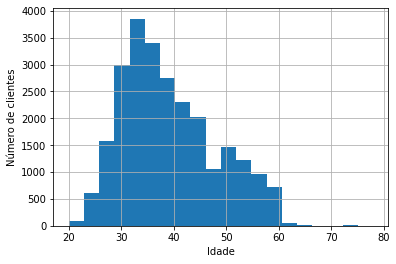

In [10]:
ax = housing['age'].hist(bins=20)
ax.set_xlabel('Idade')
ax.set_ylabel('Número de clientes');

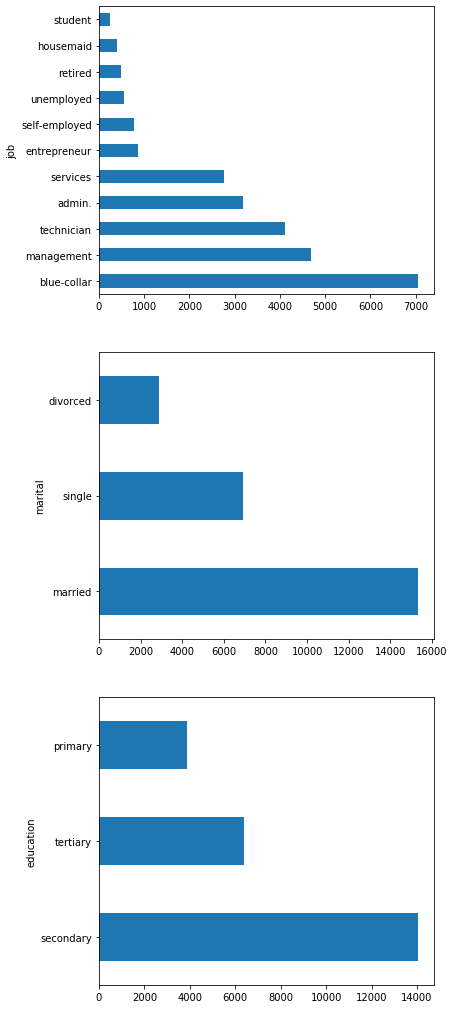

In [11]:
features = ['job', 'marital', 'education']
fig, axes = plt.subplots(3, 1, figsize=(6, 18))
axes = np.array(axes).ravel()
for feature, ax in zip(features, axes):
    housing\
        .groupby(feature)\
        .size()\
        .sort_values(ascending=False)\
        .plot.barh(ax=ax)

Sendo assim, marginalmente o cliente que contratou um financiamento imobiliário é:

- Entre 30 e 40 anos
- *Blue-collar*
- Casado
- Ensino Médio completo

Podemos imaginar a *persona* desse cliente majoritário como alguém de emprego e relacionamento estável e busca um novo passo na vida, um imóvel.

E combinando? Talvez outras combinações surjam do que a *persona* indicada anteriormente.

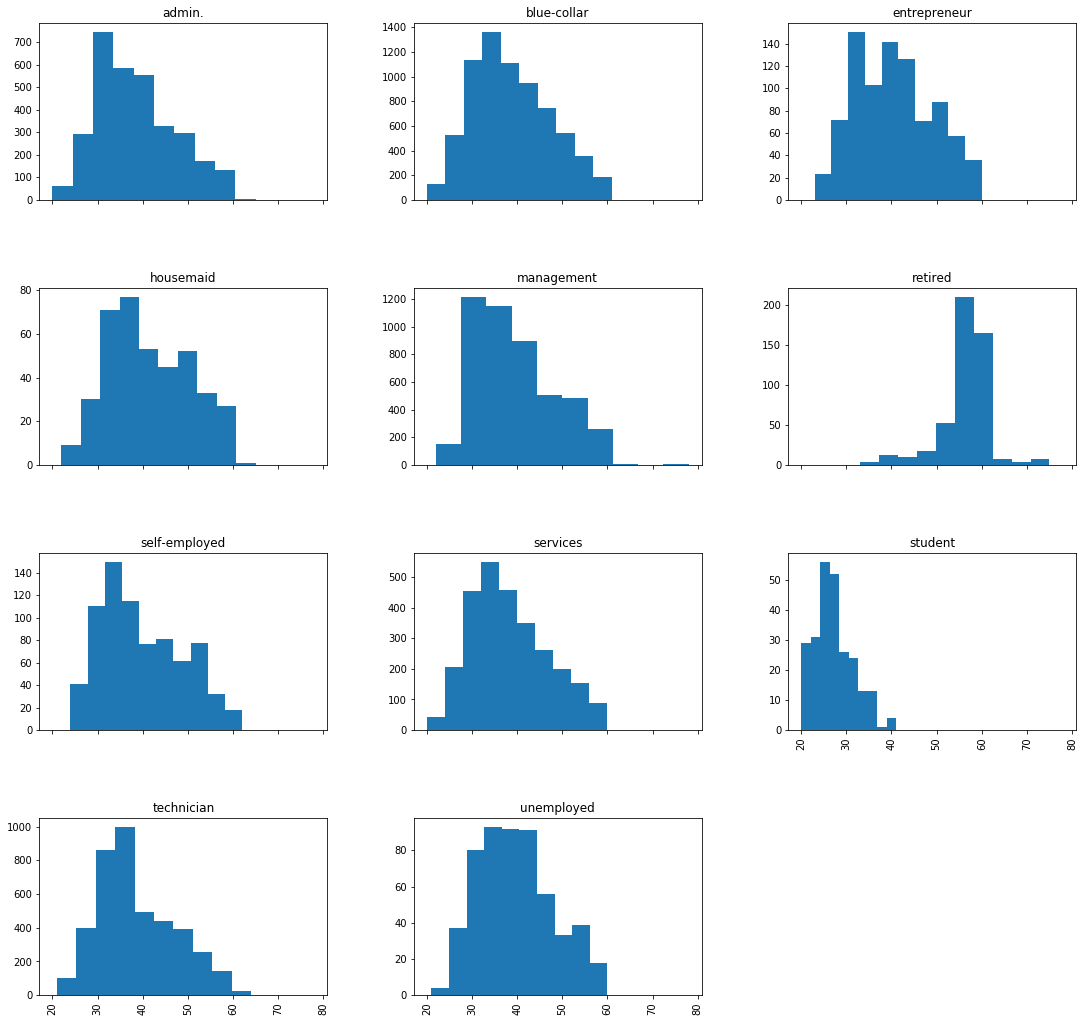

In [12]:
housing.hist(column='age', by='job', figsize=(18,18), sharex=True);

Vendo a distribuição de idade por categoria de emprego, concluímos que a faixa dos 30-40 é a faixa mais frequente em quase todas as categorias, sendo improvável que seja afetada pela combinação dos atributos categóricos.

In [13]:
housing\
    .groupby(['job', 'education', 'marital'])\
    .size()\
    .sort_values(ascending=False)\
    .head(5)\
    .rename('clients')\
    .to_frame()

,,,clients
job,education,marital,
blue-collar,secondary,married,2798
management,tertiary,married,2070
blue-collar,primary,married,2061
technician,secondary,married,1614
services,secondary,married,1363


Observamos, então, uma diferença interessante para a *persona* marginal que obtivemos antes.
De fato, tal conjunto de características é a mais frequente, mas surgiu um outro que merece destaque:

- Casado
- Entre 30 e 40 anos
- Com Ensino Superior
- Exercendo cargos gerenciais

Esse personagem também busca financiamentos imobiliários.
Mas como, marginalmente, não é aparente, ficou oculto.
A grande diferença entre os dois está na correlação entre a escolaridade e o cargo que ocupa nas empresas que trabalham.
O básico, serem casados, na faixa dos 30, se manteve.